# Keyword Spotting

Download the repository and needed packages:

In [ ]:
!git clone https://github.com/khaykingleb/KWS.git

In [ ]:
!pip install -r KWS/requirements.txt

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt

import tqdm
from pathlib import Path
from IPython import display

import pandas as pd

import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import sys
sys.path.append('KWS/')

from configs import *
from main import main

from kws.augmentations import LogMelSpec

## Downloading data

In [ ]:
%%bash
mkdir ./KWS/data

wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz \
  -O ./KWS/data/speech_commands_v0.01.tar.gz

mkdir ./KWS/data/speech_commands && tar -C ./KWS/data/speech_commands \
  -xvzf ./KWS/data/speech_commands_v0.01.tar.gz 1> log

rm ./KWS/data/speech_commands_v0.01.tar.gz

In [ ]:
%%bash
mkdir ./KWS/saved

## Streaming

For this part, the ["Streaming keyword spotting on mobile devices"](https://arxiv.org/pdf/2005.06720v2.pdf) paper is used.

"Streaming mode means that the model receives portion of the input sequence and classifies it incrementally. In a KWS application we do not know when the keyword starts or ends, so we need to process every audio packet and return the classification results in real time every 20ms (for example) — it is called streaming inference."

But, at first, let's train our base model to use it as a benchmark for comparision.

In [ ]:
config = Config()

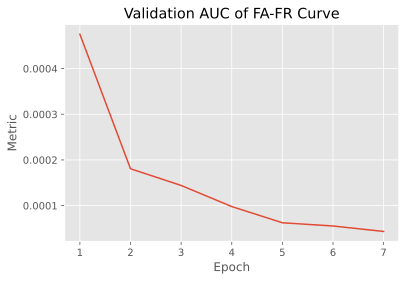

Epoch 7: AUC_FA_FR = 4.33841e-05
Achieved the threshold successively.
Elapsed time: 770.66.
MACs: 339648.0.
Parameters: 70443.0.
Size in megabytes: 0.2687.


In [ ]:
config.model_name = "base_2x64"
base_2x64_result = main(config)

Now we can try streaming:

In [ ]:
from kws.models import CRNNStreaming

streaming_model = CRNNStreaming(config=config).to(config.device) 
streaming_model.load_state_dict(torch.load("KWS/saved/base_2x64_best.pth")["state_dict"])

In [ ]:
def visualize_audio(wav: torch.Tensor, sr: int = 22050):
    if wav.dim() == 2:
        wav = wav.mean(dim=0)
    
    plt.figure(figsize=(14, 6))
    plt.plot(wav, alpha=0.7, c="green")
    plt.xlabel("Time", size=16)
    plt.ylabel("Amplitude", size=16)
    plt.show()
    
    display.display(display.Audio(wav, rate=sr))

In [ ]:
CURRENT_DIR = Path().absolute().resolve()

words = [
    "on", "sheila", "off"
]

audio_overall = torch.Tensor([])

for word in words:
    try:
        audio_path = CURRENT_DIR / f"KWS/data/speech_commands/{word}/" \
                                    "004ae714_nohash_0.wav"
        audio, sr = torchaudio.load(audio_path)
    except RuntimeError:
        continue
    audio_overall = torch.cat((audio_overall, audio), dim=-1)

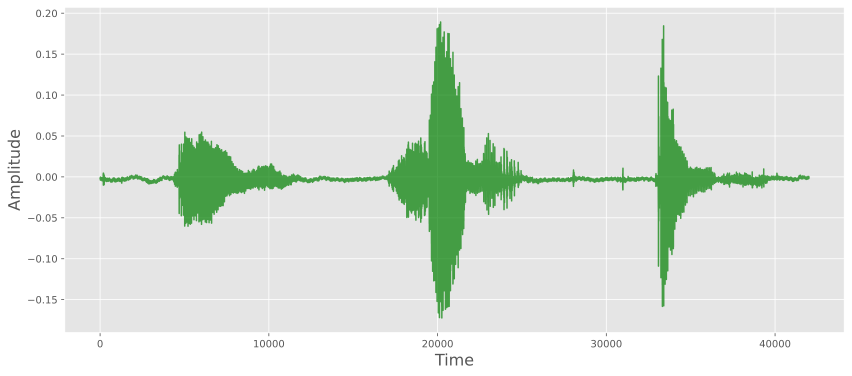

In [ ]:
visualize_audio(audio_overall, sr)

In [ ]:
def plot_audio_inference(streaming_model, audio, config):
    streaming_model.eval()

    melspec = LogMelSpec(is_train=False, config=config)
    spectrogram = melspec(audio.to(config.device))

    if len(spectrogram.shape) == 2:
        spectrogram.unsqueeze(0)

    hidden = None
    history = []

    streaming_model.set_buffer(spectrogram)

    for T in range(config.max_window_length, 
                   spectrogram.shape[2] + 1, config.streaming_step_size):
        window = spectrogram[:, :, T - config.max_window_length:T]
        if hidden is not None:
            hidden.to(config.device)
        probs, hidden = streaming_model.inference(window.to(config.device), hidden)
        history.append(probs[0][1]) 

    plt.plot(history)
    plt.title("Probability of a keyword", loc="left")
    plt.xlabel("Frame")
    plt.ylabel("Probability")

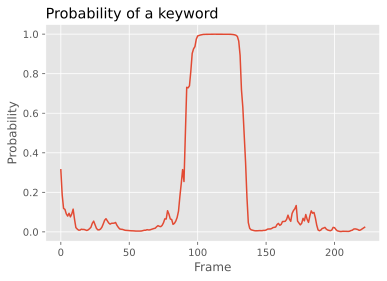

In [ ]:
plot_audio_inference(streaming_model, audio_overall, config)

As we see, everything works fine, as we expected: the probability of a keyword increases on the timeframes where some part of the `sheila` word is presented in the corresponding spectrogram.

## Speeding up and Compression 

### Distillation

For this part, this [blog](https://medium.com/neuralmachine/knowledge-distillation-dc241d7c2322) was used. Here, I've tried 50 and 100 epochs to achieve the threshold using the small model ($1x20$, that is a model with a GRU layer and hidden of size 20).

In [ ]:
small_config = SmallConfig()

In [ ]:
config.num_epochs = 100
config.model_name = "distilled_1x20"
small_config.path_to_load = "KWS/saved/base_2x64_best.pth"

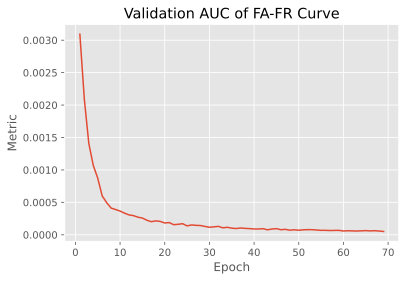

Epoch 69: AUC_FA_FR = 5.08972e-05
Achieved the threshold successively.
Elapsed time: 7432.73.
MACs: 65520.0.
Parameters: 7708.0.
Size in megabytes: 0.0294.


In [ ]:
distilled_1x20_result = main(config, small_config)

Also, I have tried to use different temperature and alpha in the weighted loss $\mathcal{L} = \alpha\mathcal{L}_{distillation} + (1 - \alpha)\mathcal{L}_{student}$ for smaller models but it would require a lot of epochs—around 200 or 300—to reach the threshold quality.

In [ ]:
small_config_new = SmallConfig()

In [ ]:
config.model_name = "distilled_1x8"
config.num_epochs = 150
small_config_new.temperature = 100
small_config_new.hidden_size = 16
small_config_new.path_to_load = "KWS/saved/base_2x64_best.pth"

In [ ]:
distilled_1x8_result = main(config, small_config_new)

### Quantization

It is used in post-training. So, we will compare—in the `results` section—all pretrained models on the validation set.

In [ ]:
from kws.trainer import validation
from kws.metrics import get_auc_FA_FR
from kws.datasets import SpeechCommandDataset
from kws.collate_fn import Collator
from kws.utils import *

In [ ]:
seed_everything(seed=config.seed)

dataset = SpeechCommandDataset(path_to_dir=config.path_to_data, keywords=config.keyword)
indexes = torch.randperm(len(dataset))
val_indexes = indexes[int(len(dataset) * config.train_ratio):]

df_val = dataset.csv.iloc[val_indexes].reset_index(drop=True)
val_set = SpeechCommandDataset(csv=df_val)
val_loader = DataLoader(val_set, 
                        batch_size=config.batch_size,
                        shuffle=False, 
                        collate_fn=Collator(),
                        num_workers=config.num_workers, 
                        pin_memory=True)

In [ ]:
def evaluate_on_validation_set(model, val_loader, config, 
                               log_melspec=LogMelSpec(is_train=False, config=config)):
    model.eval()
    all_probs, all_labels = [], []

    with Timer(verbose=config.verbose) as timer:
        for _, (batch, labels) in enumerate(val_loader):
            batch = log_melspec(batch)
            output = model(batch)
            probs = F.softmax(output, dim=-1)
            
            all_probs.append(probs[:, 1])
            all_labels.append(labels)
        
        time = timer.get_time()

    auc_fa_fr = get_auc_FA_FR(torch.cat(all_probs, dim=0), all_labels)
    macs, num_params = profile(model, torch.zeros(1, 1, 40, 50), verbose=False)
    size = get_size_in_megabytes(model)

    result_val = {
        "model": config.model_name,
        "macs": macs, 
        "num_params": num_params,
        "size": size,
        "time": time,
        "quality": auc_fa_fr
    }

    return result_val

1. `base_2x64_32fp`

In [ ]:
base_2x64_32fp_model = CRNNStreaming(config=config).to(config.device) 
base_2x64_32fp_model.load_state_dict(torch.load("KWS/saved/base_2x64_best.pth")["state_dict"])

config.model_name = "base_2x64_32fp"
base_2x64_fp32_result_val = evaluate_on_validation_set(base_2x64_32fp_model, val_loader, config)

2. `base_2x64_int8`

In [ ]:
base_2x64_int8_model = CRNNStreaming(config=config)
base_2x64_int8_model.load_state_dict(torch.load("KWS/saved/base_2x64_best.pth")["state_dict"])

base_2x64_int8_model = torch.quantization.quantize_dynamic(
    base_2x64_int8_model, {nn.GRU, nn.Linear}, dtype=torch.qint8
)

config.model_name = "base_2x64_int8"
base_2x64_int8_result_val = evaluate_on_validation_set(base_2x64_int8_model, val_loader, config)

3. `distilled_1x20_fp32`

In [ ]:
distilled_1x20_fp32_model = CRNNStreaming(config=small_config)
distilled_1x20_fp32_model.load_state_dict(torch.load("KWS/saved/distilled_1x20_best.pth")["state_dict"])

config.model_name = "distilled_1x20_fp32"
distilled_1x20_fp32_result_val = evaluate_on_validation_set(distilled_1x20_fp32_model, val_loader, config)

4. `distilled_1x20_int8`

In [ ]:
distilled_1x20_int8_model = CRNNStreaming(config=small_config)
distilled_1x20_int8_model.load_state_dict(torch.load("KWS/saved/distilled_1x20_best.pth")["state_dict"])

distilled_1x20_int8_model = torch.quantization.quantize_dynamic(
    distilled_1x20_int8_model, {nn.GRU, nn.Linear}, dtype=torch.qint8
)

config.model_name = "distilled_1x20_int8"
distilled_1x20_int8_result_val = evaluate_on_validation_set(distilled_1x20_int8_model, val_loader, config)

# Results

In [ ]:
results = [
    base_2x64_result_val, base_2x64_int8_result_val,
    distilled_1x20_fp32_result_val, distilled_1x20_int8_result_val
]

In [ ]:
results = pd.DataFrame(results)

results["compression_rate"] = \
   results[results["model"] == "base_2x64_32fp"]["size"].values / results["size"]
   
results["speedup_rate"] = \
    results[results["model"] == "base_2x64_32fp"]["macs"].values / results["macs"]

In [ ]:
results

,model,macs,num_params,size,time,quality,compression_rate,speedup_rate
0,base_2x64_32fp,339648.0,70443.0,0.268719,13.783635,0.000043,1.000000,1.000000
1,base_2x64_int8,58176.0,808.0,0.003082,12.437310,0.000044,87.181931,5.838284
2,distilled_1x20_fp32,65520.0,7708.0,0.029404,13.333211,0.000051,9.138947,5.183883
3,distilled_1x20_int8,36360.0,505.0,0.001926,12.417065,0.000052,139.491089,9.341254


In [ ]:
def plot_comparision(column):
    fig, ax = plt.subplots(figsize=(10, 6))

    plt.title(f"AUC FA-FR vs. {column.capitalize()}")
    plt.ylabel("AUC FA-FR")
    plt.xlabel(column.capitalize())

    results_base = results[results["model"].str.startswith("base")]
    plt.plot(results_base[column], results_base["quality"])
    plt.scatter(results_base[column], results_base["quality"])

    results_distill = results[results["model"].str.startswith("distilled")]
    plt.plot(results_distill[column], results_distill["quality"])
    plt.scatter(results_distill[column], results_distill["quality"])

    for _, result in results.iterrows():
        ax.annotate(result["model"], xy=(result[column], result["quality"]),
                    xytext=(result[column], result["quality"] + 1.5e-7))
        

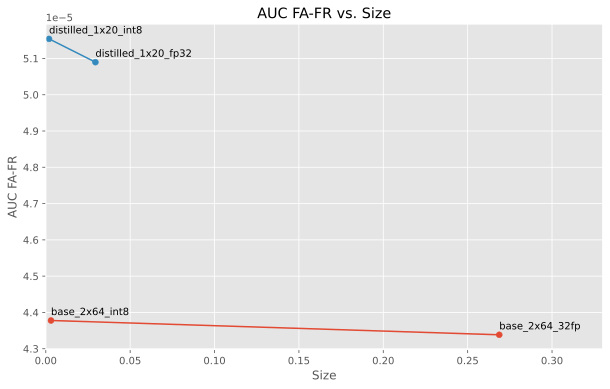

In [ ]:
plot_comparision("size")
plt.xlim(0, 0.33);

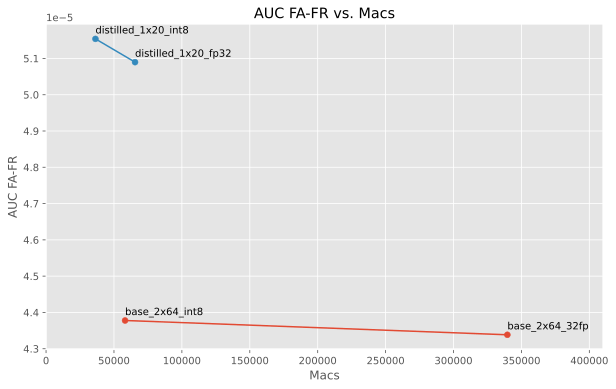

In [ ]:
plot_comparision("macs")
plt.xlim(0, 410000);

As we can see the `distilled_1x20_int8` model, which is a small student model with quantization, is the best one to accelerate our base model `base_2x64_32fp`. Obviously, we can see a little drop in the quality of such a model.

Expected grade is:

In [ ]:
best_model = results[results["model"] == "distilled_1x20_int8"]
round(4 + 4 * (best_model["speedup_rate"].values / 10)[0] + 2, 2)

9.74

What worked and what didn't work?

I guess, everything worked as expected:

* Streaming showed a high probability of a keyword when the component of the word `sheila` is presented on the corresponding spectrogram.

* Distillation decreased the number of parameters of our model. Though, there is a limit to it: I couldn't train `distilled_1x8` model for the desired quality threshold.

* Quantization made our model a little bit faster.

What were the major challenges?

1) Constantly changing base model and the notebook. 

2) Few materials with examples on the topic.
